In [4]:
import numpy as np 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.metrics import silhouette_score


In [5]:
data_path = "./Data_Providers/"
df_providers_class_content = pd.read_csv(data_path + 'content_overview_new_202509.csv')
df_providers_class_service = pd.read_csv(data_path + 'service_overview_new_202509.csv')

In [6]:
df_providers_class_content = df_providers_class_content[df_providers_class_content.columns[0:-1]].dropna()
df_providers_class_service = df_providers_class_service[df_providers_class_service.columns[0:-1]].dropna()

In [7]:
print(df_providers_class_content.describe()), print(df_providers_class_service.describe())

       map_matching    exclusive    redundant
count   9114.000000  9114.000000  9114.000000
mean       0.840237     0.474961     0.052067
std        0.335768     0.461432     0.114436
min        0.000000     0.000000     0.000000
25%        0.944591     0.000000     0.000000
50%        0.983904     0.477464     0.000000
75%        0.997986     0.987116     0.054537
max        1.000000     1.000000     1.000000
       availability     freshness  contribution    usability        frc_0  \
count   7982.000000   7982.000000   7982.000000  7982.000000  7982.000000   
mean       0.891519    666.559122      0.050067     0.295489     0.086531   
std        0.288455   2072.644481      0.122592     0.325912     0.208425   
min        0.000000      0.000000      0.000000     0.000000     0.000000   
25%        0.995210      0.570000      0.000000     0.000000     0.000000   
50%        0.999772      5.510000      0.000028     0.222054     0.000000   
75%        1.000000    113.600000      0.029075

(None, None)

In [8]:
df_providers_class_content

,feed,country_code,server,date,instance,map_matching,exclusive,redundant
0,ANWB_Netherlands,NLD,prod-bhnl-002.lt-prod.tti.az.tt3.com,2024-09-01,prod-bhnl-001.*,0.994946,0.519985,0.181549
1,ANWB_Netherlands,NLD,prod-bhom-nl-002.lt-prod.tti.az.tt3.com,2024-09-01,prod-bhom-nl-001.*,0.995204,0.573780,0.161321
2,CE_CzechRepublic_Incident,CZE,prod-bhbalticstates-a-002.lt-prod.tti.az.tt3.com,2024-09-01,prod-bhbalticstates-a-001.*,1.000000,0.996305,0.157217
3,CE_CzechRepublic_Incident,CZE,prod-bhom-balticstates-a-002.lt-prod.tti.az.tt...,2024-09-01,prod-bhom-balticstates-a-001.*,1.000000,0.987572,0.156118
4,CE_Poland_Incident,POL,prod-bhbalticstates-a-002.lt-prod.tti.az.tt3.com,2024-09-01,prod-bhbalticstates-a-001.*,0.985722,0.990572,0.292698
...,...,...,...,...,...,...,...,...
9109,wvdoh_incidents_usa,USA,prod-bhom-usa-f-001.lt-prod.tti.az.tt3.com,2025-08-01,prod-bhom-usa-f-001.*,0.000000,0.000000,0.000000
9110,wvdoh_roadworks_usa,USA,prod-bhom-usa-e-001.lt-prod.tti.az.tt3.com,2025-08-01,prod-bhom-usa-e-001.*,0.000000,0.000000,0.000000
9111,wvdoh_roadworks_usa,USA,prod-bhom-usa-f-001.lt-prod.tti.az.tt3.com,2025-08-01,prod-bhom-usa-f-001.*,0.000000,0.000000,0.000000
9112,wvdoh_roadworks_usa,USA,prod-bhusa-e-001.lt-prod.tti.az.tt3.com,2025-08-01,prod-bhusa-e-001.*,0.000000,0.000000,0.000000


In [9]:
df_providers_class_service

,feed,country_code,server,date,availability,freshness,contribution,usability,frc_0,frc_1,...,frc_6,frc_7,weather,security_alert,activity,accidents,road_condition,roadworks,closures,hazards
0,ANWB_Netherlands,NLD,prod-bhnl-001.lt-prod.tti.az.tt3.com,2024-09-01,1.0,1.03,0.015911,0.384977,0.653941,0.135505,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.071425,0.000628,0.085295,0.825352,0.017156
1,ANWB_Netherlands,NLD,prod-bhom-nl-001.lt-prod.tti.az.tt3.com,2024-09-01,1.0,1.03,0.018056,0.354566,0.629760,0.281381,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.055208,0.000343,0.155704,0.775124,0.013506
2,CE_CzechRepublic_Incident,CZE,prod-bhbalticstates-a-001.lt-prod.tti.az.tt3.com,2024-09-01,1.0,0.83,0.335059,0.770443,0.027918,0.053302,...,0.040293,0.009495,0.000010,0.005469,0.000418,0.016473,0.000000,0.283140,0.547219,0.007036
3,CE_CzechRepublic_Incident,CZE,prod-bhom-balticstates-a-001.lt-prod.tti.az.tt...,2024-09-01,1.0,0.83,0.329915,0.785483,0.027803,0.034353,...,0.001391,0.043662,0.000009,0.005292,0.000426,0.016045,0.000000,0.294032,0.543430,0.006599
4,CE_Poland_Incident,POL,prod-bhbalticstates-a-001.lt-prod.tti.az.tt3.com,2024-09-01,1.0,0.60,0.220945,0.389948,0.009466,0.272076,...,0.028850,0.010066,0.000000,0.000000,0.000106,0.006434,0.000000,0.769566,0.223893,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7977,wvdoh_incidents_usa,USA,prod-bhusa-f-001.lt-prod.tti.az.tt3.com,2025-07-01,0.0,8863.68,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7978,wvdoh_roadworks_usa,USA,prod-bhom-usa-e-001.lt-prod.tti.az.tt3.com,2025-07-01,0.0,8863.74,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7979,wvdoh_roadworks_usa,USA,prod-bhom-usa-f-001.lt-prod.tti.az.tt3.com,2025-07-01,0.0,8863.74,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7980,wvdoh_roadworks_usa,USA,prod-bhusa-e-001.lt-prod.tti.az.tt3.com,2025-07-01,0.0,8863.74,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
df_providers_class_content["instance"][0][0:-1] in df_providers_class_service.loc[2, "server"]


False

In [11]:
df_new = pd.DataFrame()

row = []

for i in range(len(df_providers_class_service)):
    for j in range(len(df_providers_class_content)):
        if df_providers_class_content["instance"][j][0:-1] in df_providers_class_service.loc[i, "server"] and df_providers_class_content["feed"][j] == df_providers_class_service["feed"][i] and df_providers_class_content["date"][j] == df_providers_class_service["date"][i]:
        
            # build row
            row = {
                "feed": df_providers_class_service.loc[i, "feed"],
                "server": df_providers_class_service.loc[i, "server"],
                "map_matching": df_providers_class_content.loc[j, "map_matching"],
                "exclusive": df_providers_class_content.loc[j, "exclusive"],
                "redundant": df_providers_class_content.loc[j, "redundant"],
                "accidents": df_providers_class_service.loc[i, "accidents"],
                "hazards": df_providers_class_service.loc[i, "hazards"],
                "closures": df_providers_class_service.loc[i, "closures"],
                "freshness": df_providers_class_service.loc[i, "freshness"],
                "contribution": df_providers_class_service.loc[i, "contribution"],
                "usability": df_providers_class_service.loc[i, "usability"],
                "availability": df_providers_class_service.loc[i, "availability"],

            }
            row = pd.DataFrame([row])
            # append row to dataframe
            df_new = pd.concat([df_new, row])
          
    print("cycle i:", i, " out of ", len(df_providers_class_service))

cycle i: 0  out of  7982
cycle i: 1  out of  7982
cycle i: 2  out of  7982
cycle i: 3  out of  7982
cycle i: 4  out of  7982
cycle i: 5  out of  7982
cycle i: 6  out of  7982
cycle i: 7  out of  7982
cycle i: 8  out of  7982
cycle i: 9  out of  7982
cycle i: 10  out of  7982
cycle i: 11  out of  7982
cycle i: 12  out of  7982
cycle i: 13  out of  7982
cycle i: 14  out of  7982
cycle i: 15  out of  7982
cycle i: 16  out of  7982
cycle i: 17  out of  7982
cycle i: 18  out of  7982
cycle i: 19  out of  7982
cycle i: 20  out of  7982
cycle i: 21  out of  7982
cycle i: 22  out of  7982
cycle i: 23  out of  7982
cycle i: 24  out of  7982
cycle i: 25  out of  7982
cycle i: 26  out of  7982
cycle i: 27  out of  7982
cycle i: 28  out of  7982
cycle i: 29  out of  7982
cycle i: 30  out of  7982
cycle i: 31  out of  7982
cycle i: 32  out of  7982
cycle i: 33  out of  7982
cycle i: 34  out of  7982
cycle i: 35  out of  7982
cycle i: 36  out of  7982
cycle i: 37  out of  7982
cycle i: 38  out of  7

In [12]:
df_new

,feed,server,map_matching,exclusive,redundant,accidents,hazards,closures,freshness,contribution,usability,availability
0,ANWB_Netherlands,prod-bhnl-001.lt-prod.tti.az.tt3.com,0.994946,0.519985,0.181549,0.071425,0.017156,0.825352,1.03,0.015911,0.384977,1.0
0,ANWB_Netherlands,prod-bhom-nl-001.lt-prod.tti.az.tt3.com,0.995204,0.573780,0.161321,0.055208,0.013506,0.775124,1.03,0.018056,0.354566,1.0
0,CE_CzechRepublic_Incident,prod-bhbalticstates-a-001.lt-prod.tti.az.tt3.com,1.000000,0.996305,0.157217,0.016473,0.007036,0.547219,0.83,0.335059,0.770443,1.0
0,CE_CzechRepublic_Incident,prod-bhom-balticstates-a-001.lt-prod.tti.az.tt...,1.000000,0.987572,0.156118,0.016045,0.006599,0.543430,0.83,0.329915,0.785483,1.0
0,CE_Poland_Incident,prod-bhbalticstates-a-001.lt-prod.tti.az.tt3.com,0.985722,0.990572,0.292698,0.006434,0.000000,0.223893,0.60,0.220945,0.389948,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
0,wvdoh_incidents_usa,prod-bhusa-f-001.lt-prod.tti.az.tt3.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8863.68,0.000000,0.000000,0.0
0,wvdoh_roadworks_usa,prod-bhom-usa-e-001.lt-prod.tti.az.tt3.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8863.74,0.000000,0.000000,0.0
0,wvdoh_roadworks_usa,prod-bhom-usa-f-001.lt-prod.tti.az.tt3.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8863.74,0.000000,0.000000,0.0
0,wvdoh_roadworks_usa,prod-bhusa-e-001.lt-prod.tti.az.tt3.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8863.74,0.000000,0.000000,0.0


In [13]:
merged_df = df_new
merged_df.describe()

,map_matching,exclusive,redundant,accidents,hazards,closures,freshness,contribution,usability,availability
count,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000,7764.000000
mean,0.885027,0.492758,0.056346,0.063465,0.040480,0.154308,672.609232,0.051473,0.303593,0.891093
std,0.279728,0.460809,0.118194,0.200562,0.139610,0.274225,2095.165368,0.124010,0.326575,0.288666
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.954393,0.000000,0.000000,0.000000,0.000000,0.000000,0.570000,0.000000,0.000000,0.995715
50%,0.984760,0.574362,0.000000,0.000000,0.000000,0.000000,6.045000,0.000219,0.246911,0.999762
75%,0.997145,0.990474,0.063080,0.003066,0.000012,0.191628,109.640000,0.032756,0.554600,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19476.850000,0.976036,1.000000,1.000000


In [14]:
merged_df.columns

Index(['feed', 'server', 'map_matching', 'exclusive', 'redundant', 'accidents',
       'hazards', 'closures', 'freshness', 'contribution', 'usability',
       'availability'],
      dtype='object')

In [15]:
df_complete = merged_df

In [16]:
merged_df.head(50)

,feed,server,map_matching,exclusive,redundant,accidents,hazards,closures,freshness,contribution,usability,availability
0,ANWB_Netherlands,prod-bhnl-001.lt-prod.tti.az.tt3.com,0.994946,0.519985,0.181549,0.071425,0.017156,0.825352,1.03,0.015911,0.384977,1.000000
0,ANWB_Netherlands,prod-bhom-nl-001.lt-prod.tti.az.tt3.com,0.995204,0.573780,0.161321,0.055208,0.013506,0.775124,1.03,0.018056,0.354566,1.000000
0,CE_CzechRepublic_Incident,prod-bhbalticstates-a-001.lt-prod.tti.az.tt3.com,1.000000,0.996305,0.157217,0.016473,0.007036,0.547219,0.83,0.335059,0.770443,1.000000
0,CE_CzechRepublic_Incident,prod-bhom-balticstates-a-001.lt-prod.tti.az.tt...,1.000000,0.987572,0.156118,0.016045,0.006599,0.543430,0.83,0.329915,0.785483,1.000000
0,CE_Poland_Incident,prod-bhbalticstates-a-001.lt-prod.tti.az.tt3.com,0.985722,0.990572,0.292698,0.006434,0.000000,0.223893,0.60,0.220945,0.389948,1.000000
0,CE_Poland_Incident,prod-bhom-balticstates-a-001.lt-prod.tti.az.tt...,0.969182,0.992428,0.289003,0.006590,0.000000,0.176819,0.60,0.209690,0.439462,1.000000
0,Infotripla_Cities_Finland,prod-bhbalticstates-b-001.lt-prod.tti.az.tt3.com,0.957470,0.968869,0.154692,0.000000,0.000000,0.220660,0.52,0.020634,0.623246,1.000000
0,Infotripla_Cities_Finland,prod-bhom-balticstates-b-001.lt-prod.tti.az.tt...,0.980898,0.936223,0.180827,0.000000,0.000000,0.163804,0.52,0.021733,0.618253,1.000000
0,Infotripla_Finland,prod-bhbalticstates-b-001.lt-prod.tti.az.tt3.com,0.959428,0.874498,0.670456,0.010912,0.001245,0.019882,0.53,0.527131,0.678582,1.000000
0,Infotripla_Finland,prod-bhom-balticstates-b-001.lt-prod.tti.az.tt...,0.959428,0.874533,0.673578,0.010875,0.001212,0.020326,0.53,0.519062,0.693660,1.000000


In [17]:
df_complete['freshness'].describe()

count     7764.000000
mean       672.609232
std       2095.165368
min          0.000000
25%          0.570000
50%          6.045000
75%        109.640000
max      19476.850000
Name: freshness, dtype: float64

In [18]:
df_complete['freshness'] = (df_complete['freshness'] - df_complete['freshness'].min()) / (df_complete['freshness'].max() - df_complete['freshness'].min())


In [19]:
df_complete

,feed,server,map_matching,exclusive,redundant,accidents,hazards,closures,freshness,contribution,usability,availability
0,ANWB_Netherlands,prod-bhnl-001.lt-prod.tti.az.tt3.com,0.994946,0.519985,0.181549,0.071425,0.017156,0.825352,0.000053,0.015911,0.384977,1.0
0,ANWB_Netherlands,prod-bhom-nl-001.lt-prod.tti.az.tt3.com,0.995204,0.573780,0.161321,0.055208,0.013506,0.775124,0.000053,0.018056,0.354566,1.0
0,CE_CzechRepublic_Incident,prod-bhbalticstates-a-001.lt-prod.tti.az.tt3.com,1.000000,0.996305,0.157217,0.016473,0.007036,0.547219,0.000043,0.335059,0.770443,1.0
0,CE_CzechRepublic_Incident,prod-bhom-balticstates-a-001.lt-prod.tti.az.tt...,1.000000,0.987572,0.156118,0.016045,0.006599,0.543430,0.000043,0.329915,0.785483,1.0
0,CE_Poland_Incident,prod-bhbalticstates-a-001.lt-prod.tti.az.tt3.com,0.985722,0.990572,0.292698,0.006434,0.000000,0.223893,0.000031,0.220945,0.389948,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
0,wvdoh_incidents_usa,prod-bhusa-f-001.lt-prod.tti.az.tt3.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.455088,0.000000,0.000000,0.0
0,wvdoh_roadworks_usa,prod-bhom-usa-e-001.lt-prod.tti.az.tt3.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.455091,0.000000,0.000000,0.0
0,wvdoh_roadworks_usa,prod-bhom-usa-f-001.lt-prod.tti.az.tt3.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.455091,0.000000,0.000000,0.0
0,wvdoh_roadworks_usa,prod-bhusa-e-001.lt-prod.tti.az.tt3.com,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.455091,0.000000,0.000000,0.0


In [20]:
#scaler = StandardScaler()
#df_scaled = df_complete.copy()
#df_scaled[cols_to_scale] = scaler.fit_transform(df_complete[cols_to_scale])

In [21]:

df = df_complete[df_complete.columns[2:]]

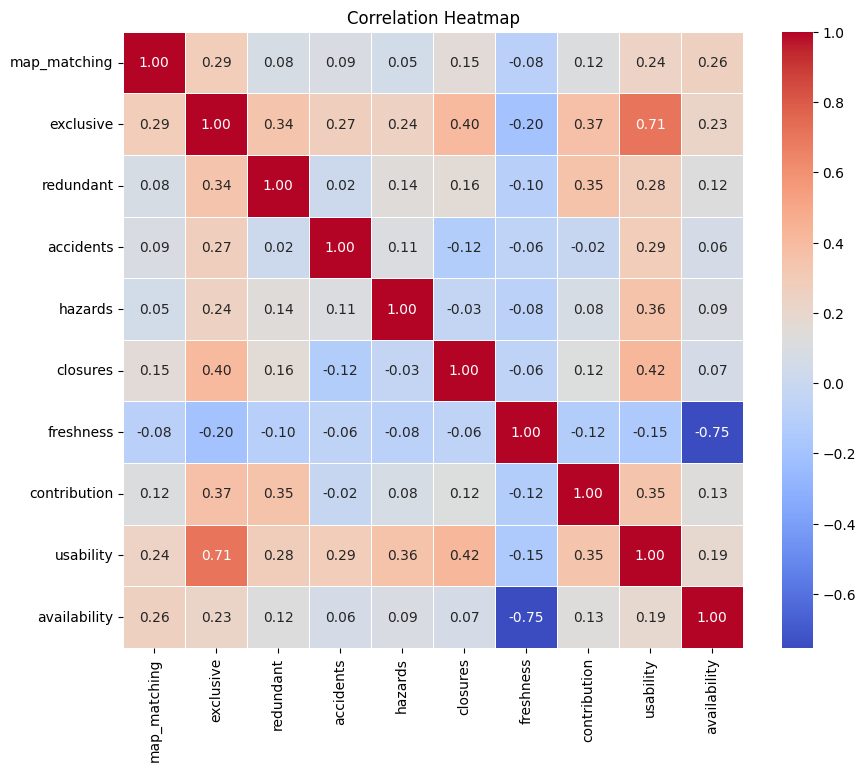

In [22]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

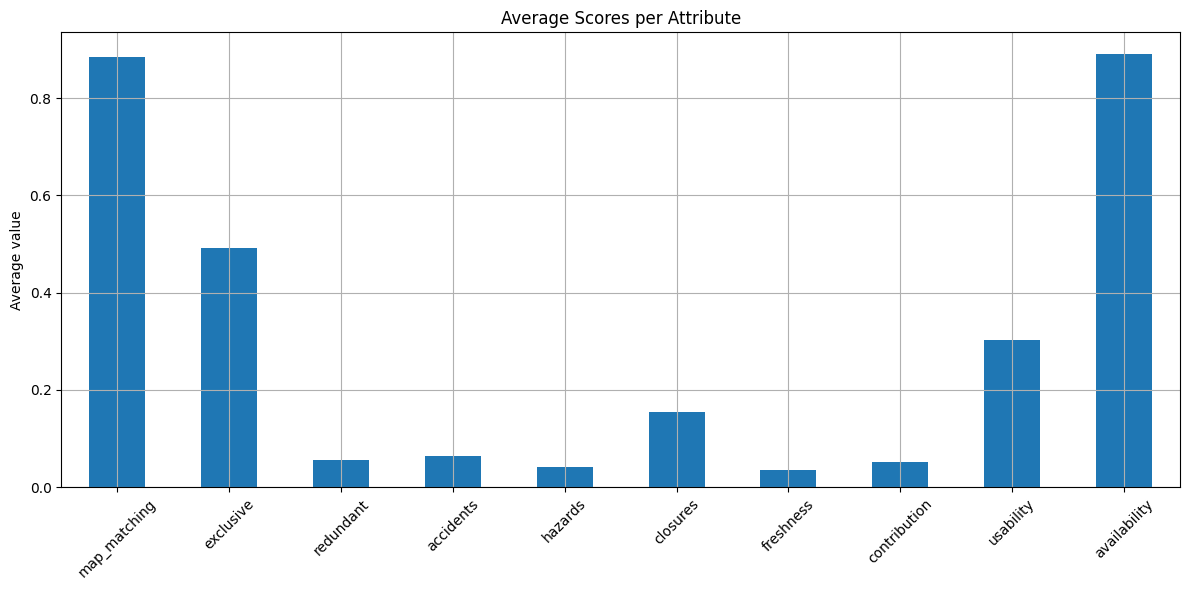

In [23]:

df_subset = df

# Plot the average value for each column
df_subset.mean().plot(kind='bar', figsize=(12, 6))
plt.ylabel('Average value')
plt.title('Average Scores per Attribute')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df.head()

,map_matching,exclusive,redundant,accidents,hazards,closures,freshness,contribution,usability,availability
0,0.994946,0.519985,0.181549,0.071425,0.017156,0.825352,0.000053,0.015911,0.384977,1.0
0,0.995204,0.573780,0.161321,0.055208,0.013506,0.775124,0.000053,0.018056,0.354566,1.0
0,1.000000,0.996305,0.157217,0.016473,0.007036,0.547219,0.000043,0.335059,0.770443,1.0
0,1.000000,0.987572,0.156118,0.016045,0.006599,0.543430,0.000043,0.329915,0.785483,1.0
0,0.985722,0.990572,0.292698,0.006434,0.000000,0.223893,0.000031,0.220945,0.389948,1.0


In [ ]:
from sklearn.mixture import GaussianMixture

def cluster_gmm(df, a=1,b=1,c=0,d=0):

    df = df[['map_matching', 'exclusive', 'redundant', 'accidents',
       'hazards', 'closures', 'freshness', 'contribution', 'usability',
       'availability']]

    # --- Fit GMM ---
    gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
    df['cluster_GMM'] = gmm.fit_predict(df)

    # --- Probabilities for each cluster ---
    proba = gmm.predict_proba(df.drop(columns=['cluster_GMM']))
    df[[f'cluster_{i}_prob' for i in range(5)]] = proba

    # --- Cluster summary
    cluster_summary = df.groupby('cluster_GMM')[['map_matching', 'redundant', 'freshness','exclusive',
                                         'availability', 'contribution', 'usability']].agg(['mean', 'min', 'max', 'count'])

    mean_cols = cluster_summary.loc[:, pd.IndexSlice[:, 'mean']]
    mean_cols.columns = mean_cols.columns.droplevel(1)

    # Average mean score
    cluster_summary['average_mean'] = mean_cols.mean(axis=1)

    # Variance score
    cluster_variance = df.groupby('cluster_GMM')[['map_matching', 'redundant', 'exclusive',
                                          'availability', 'freshness', 'contribution', 'usability']].var()
    cluster_summary['variance_score'] = cluster_variance.mean(axis=1)

    # --- Extract means for custom scoring ---
    map_matching_mean = cluster_summary[('map_matching', 'mean')]
    exclusive_mean = cluster_summary[('exclusive', 'mean')]
    redundant_mean = cluster_summary[('redundant', 'mean')]
    availability_mean = cluster_summary[('availability', 'mean')]
    freshness_mean = cluster_summary[('freshness', 'mean')]
    contribution_mean = cluster_summary[('contribution', 'mean')]
    usability_mean = cluster_summary[('usability', 'mean')]

    # --- Custom score formula ---
    cluster_summary['custom_score'] = (
        map_matching_mean + exclusive_mean + availability_mean +
        freshness_mean + contribution_mean + usability_mean - redundant_mean    
    )

    # Rank clusters by custom score
    cluster_summary['custom_rank'] = cluster_summary['custom_score'].rank(ascending=False)
    cluster_summary_mean = cluster_summary.sort_values('custom_rank', ascending=True)

    # Assign grades (custom score)
    grades = ['A+', 'A', 'B', 'C', 'D']
    cluster_summary_mean['grade'] = pd.Series(grades[:len(cluster_summary_mean)],
                                          index=cluster_summary_mean.index)

    # --- Rank by variability ---
    cluster_summary_var = cluster_summary.sort_values('variance_score', ascending=True)
    cluster_summary_var['grade'] = pd.Series(grades[:len(cluster_summary_var)],
                                         index=cluster_summary_var.index)

    rows_lb = []
    rows_ub = []
    for i in range(5):
      rows_lb.append(a * cluster_summary_mean.custom_score[i] - b * np.sqrt(cluster_summary_var.variance_score[i]) )
    cluster_summary['threshold_lb'] = rows_lb

    for i in range(5):
      rows_ub.append(a * cluster_summary_mean.custom_score[i] + b * np.sqrt(cluster_summary_var.variance_score[i]) )
    cluster_summary['threshold_ub'] = rows_ub

    # Rank by threshold
    cluster_summary_thld = cluster_summary.sort_values('threshold', ascending=False)
    cluster_summary_thld['grade'] = pd.Series(grades[:len(cluster_summary_thld)],
                                          index=cluster_summary_thld.index)

    score_pca = silhouette_score(df, df['cluster_GMM'])
    bic = gmm.bic(df[['map_matching', 'exclusive', 'redundant', 'accidents',
       'hazards', 'closures', 'freshness', 'contribution', 'usability',
       'availability']])
    aic = gmm.aic(df[['map_matching', 'exclusive', 'redundant', 'accidents',
       'hazards', 'closures', 'freshness', 'contribution', 'usability',
       'availability']])
    
    return df, cluster_summary_mean[['custom_score', 'grade']], cluster_summary_var[['variance_score', 'grade']], cluster_summary_thld[['threshold_lb','threshold_ub', 'grade']], score_pca, bic,aic

In [26]:
df_clus, df_clus_mean, df_clus_var, df_clus_thld, score_gmm, bic, aic =  cluster_gmm(df, a=1,b=1,c=0,d=0)

In [27]:
df_clus_mean, df_clus_var, df_clus_thld

(            custom_score grade
                               
 cluster_GMM                   
 0               3.351944    A+
 4               3.268724     A
 3               2.794635     B
 1               1.977037     C
 2               0.693245     D,
             variance_score grade
                                 
 cluster_GMM                     
 1                 0.000678    A+
 0                 0.021976     A
 2                 0.031397     B
 4                 0.039020     C
 3                 0.075526     D,
             threshold grade
                            
 cluster_GMM                
 0            0.859246    A+
 4            0.768232     A
 3            0.304741     B
 1           -0.369488     C
 2           -1.562731     D)

In [28]:
score_gmm, aic, bic

(0.7133649163979021,
 np.float64(-381276.10027364705),
 np.float64(-378987.164054976))

In [92]:
def cluster_kmeans(df, a=1,b=1.960):

    kmeans = KMeans(n_clusters=5, random_state=42)
    df['cluster'] = kmeans.fit_predict(df)

    cluster_summary = df.groupby('cluster')[['map_matching', 'redundant', 'freshness','exclusive', 'availability', 'contribution', 'usability']].agg(['mean', 'min', 'max', 'count'])
    mean_cols = cluster_summary.loc[:, pd.IndexSlice[:, 'mean']]

    # Rename columns for easier access (optional)
    mean_cols.columns = mean_cols.columns.droplevel(1)  # drop second level 'mean'

    # Now calculate average of the three feature means for each cluster
    cluster_summary['average_mean'] = mean_cols.mean(axis=1)

    cluster_variance = df.groupby('cluster')[['map_matching', 'redundant', 'exclusive', 'availability', 'freshness', 'contribution', 'usability']].var()
    cluster_summary['variance_score'] = cluster_variance.mean(axis=1)

    # Extract individual mean values
    map_matching_mean = cluster_summary[('map_matching', 'mean')]
    exclusive_mean = cluster_summary[('exclusive', 'mean')]
    redundant_mean = cluster_summary[('redundant', 'mean')]
    availability_mean = cluster_summary[('availability', 'mean')]
    freshness_mean = cluster_summary[('freshness', 'mean')]
    contribution_mean = cluster_summary[('contribution', 'mean')]
    usability_mean = cluster_summary[('usability', 'mean')]
    # Apply the custom scoring formula
    cluster_summary['custom_score'] = map_matching_mean + exclusive_mean + availability_mean + freshness_mean + contribution_mean + usability_mean - redundant_mean

    # Rank clusters by custom score
    cluster_summary['custom_rank'] = cluster_summary['custom_score'].rank(ascending=False)

    # Sort clusters by average_mean descending (best quality first)
    cluster_summary_mean = cluster_summary.sort_values('custom_rank', ascending=True)

    # Define grades to assign by rank
    grades = ['A+', 'A', 'B', 'C', 'D']

    # Assign grades based on rank position
    cluster_summary_mean['grade'] = pd.Series(grades[:len(cluster_summary_mean)], index=cluster_summary_mean.index)
    cluster_summary_mean[['custom_score', 'grade']]

    # Sort clusters by variability ascending (best quality first)
    cluster_summary_var = cluster_summary.sort_values('variance_score', ascending=True)

    # Define grades to assign by rank
    grades = ['A+', 'A', 'B', 'C', 'D']

    # Assign grades based on rank position
    cluster_summary_var['grade'] = pd.Series(grades[:len(cluster_summary_var)], index=cluster_summary_var.index)
    cluster_summary_var[['variance_score', 'grade']]
    cluster_summary['threshold'] = np.zeros(5)
    rows_lb = []
    rows_ub = []
    for i in range(5):
        rows_lb.append(a * cluster_summary_mean.custom_score[i] - b * np.sqrt(cluster_summary_var.variance_score[i]) )
    cluster_summary['threshold_lb'] = rows_lb

    for i in range(5):
        rows_ub.append(a * cluster_summary_mean.custom_score[i] + b * np.sqrt(cluster_summary_var.variance_score[i]) )
    cluster_summary['threshold_ub'] = rows_ub

    # Sort clusters by variability ascending (best quality first)
    cluster_summary_thld= cluster_summary.sort_values('threshold_ub', ascending=False)

    # Define grades to assign by rank
    grades = ['A+', 'A', 'B', 'C', 'D']

    # Assign grades based on rank position
    cluster_summary_thld['grade'] = pd.Series(grades[:len(cluster_summary_thld)], index=cluster_summary_thld.index)

    score_pca = silhouette_score(df, df['cluster'])
    
    return df, cluster_summary_mean[['custom_score', 'grade']], cluster_summary_var[['variance_score', 'grade']], cluster_summary_thld[['threshold_lb', 'threshold_ub','grade']].sort_index(), score_pca


In [30]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D  # Needed even if not directly used

def plot(df, var_name):


    fig = plt.figure(figsize=(18, 6))  # Wider layout for side-by-side

    # Define your triplets and titles
    plot_configs = [
    ('accidents', 'hazards', 'closures', 'Incident Coverage'),
    ('exclusive', 'redundant', 'contribution', 'Data Richness'),
    ('freshness', 'availability', 'map_matching', 'Service Performance')]

    # Loop to create subplots
    for idx, (x_col, y_col, z_col, title) in enumerate(plot_configs, start=1):
        ax = fig.add_subplot(1, 3, idx, projection='3d')
    
        scatter = ax.scatter(
            df[x_col],
            df[y_col],
            df[z_col],
            c=df[var_name],
            cmap='tab10',
            s=50,
            alpha=0.8
        )
    
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)

        # Apply consistent inversion logic if needed (edit per axis logic)
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.invert_zaxis()
    
        ax.set_title(title)

    # Shared legend (outside of plot area)
    handles = [
        Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
        for i in sorted(df[var_name].unique())
    ]

    fig.legend(handles=handles, title='Clusters', loc='center right', bbox_to_anchor=(1.05, 0.5))
    fig.suptitle('3D Scatter Plots by Dimension Group', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 1])  # shrink plot area slightly more
    fig.subplots_adjust(wspace=0.3)        # increase horizontal space between subplots

    plt.show()


In [93]:
df_kmean, df_kmean_mean,df_kmean_var, df_kmeans_thld, kmean_metric = cluster_kmeans(df, a=1)
df_kmeans_thld

C:\Users\fabera\AppData\Local\Temp\ipykernel_30292\2365179095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(df)


,threshold_lb,threshold_ub,grade
,,,
cluster,,,
0,3.049761,3.600045,A
1,1.887673,2.150605,B
2,0.360105,1.090611,D
3,1.314831,2.064975,C
4,3.229729,3.873962,A+


np.float64(1.3148308456865239)

In [ ]:
grades = ['A+', 'A', 'B', 'C', 'D']
for j in range (len(df_kmeans_thld) - 1):
    for idx in range(grades):
        if df_kmeans_thld['grade'][j] == grades[idx]:
            if df_kmeans_thld['threshold_lb'][j] > df_kmeans_thld['threshold_lb'][j + 1]

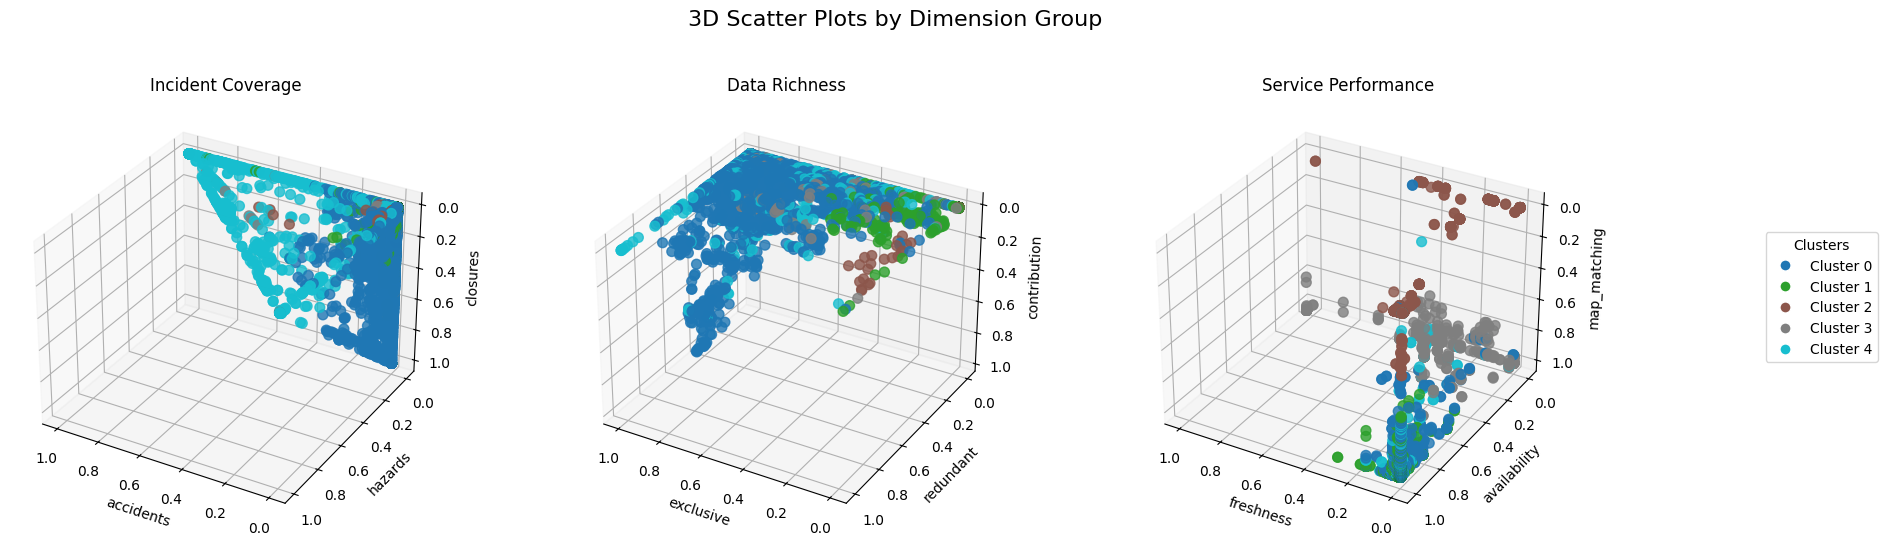

Silhouette score:  0.6874162615074524


In [32]:
var_name = 'cluster'
plot(df, var_name)
print ("Silhouette score: " , kmean_metric)

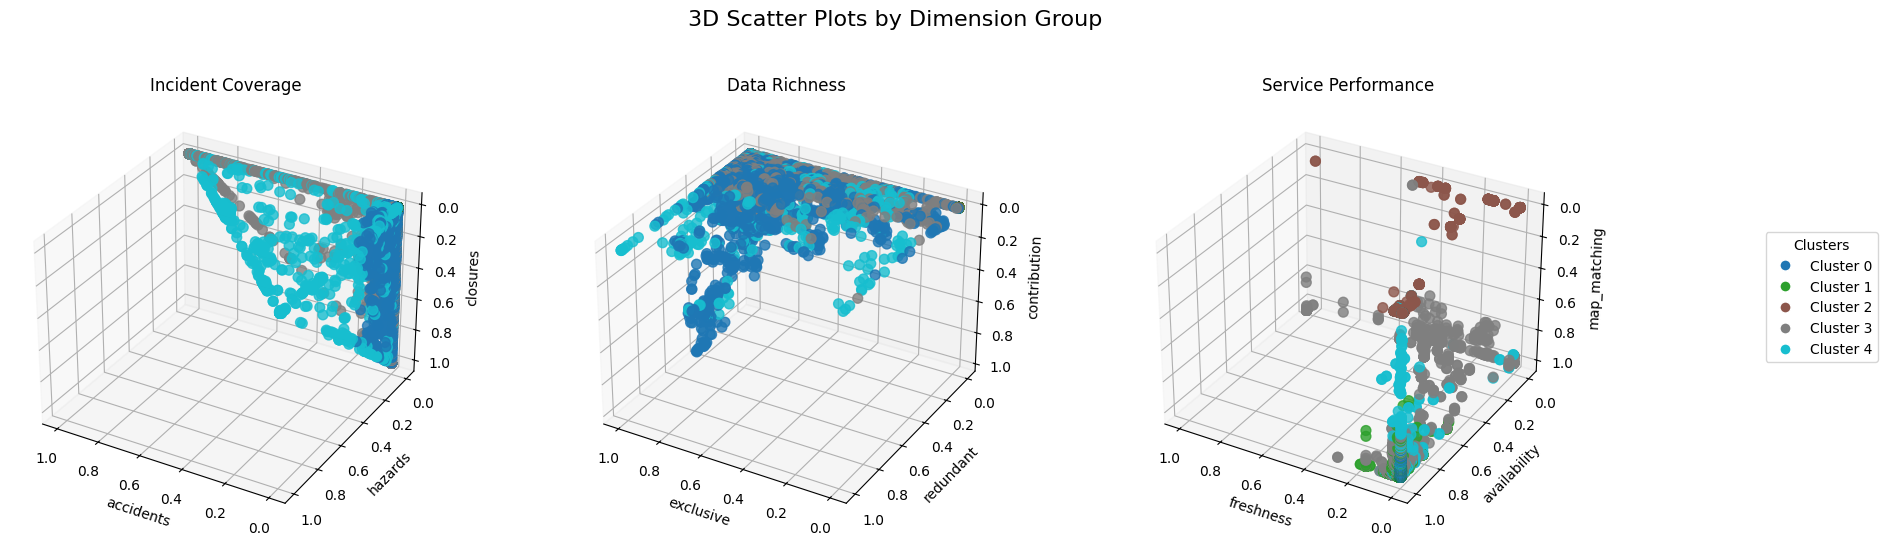

Silhouette score:  0.7133649163979021


In [33]:
var_name = 'cluster_GMM'
plot(df_clus, var_name)
print ("Silhouette score: " , score_gmm)

In [34]:
market_req = pd.DataFrame({"Accuracy_lb": [0, 0.15, 0.5,0.85,0.95],"Completeness_lb": [0,0.10,0.4,0.6,0.90],"Correctness_lb": [0,0.15,0.5,0.85,0.95], "Availability_lb": [0,0.85,0.95,0.97,0.99], "Timelineness_lb": [0,0.15,0.8,0.85,0.95], "Usability_lb": [0,0.15,0.5,0.85,0.95] , 
                              "Accuracy_ub": [0.15, 0.50, 0.85,0.95,1],"Completeness_ub": [0.1,0.4,0.6,0.9,1],"Correctness_ub": [0.15,0.5,0.85,0.95,1], "Availability_ub": [0.85,0.95,0.97,0.99,1], "Timelineness_ub": [0.15,0.8,0.85,0.95,1], "Usability_ub": [0.15,0.5,0.85,0.95,1] })
market_req['Classification'] = ["D", "C", "B", "A", "A+"]


In [82]:
market_req[market_req.columns[0]][market_req['Classification']=='A'] , market_req[market_req.columns[6]][market_req['Classification']=='A']

(3    0.85
 Name: Accuracy_lb, dtype: float64,
 3    0.95
 Name: Accuracy_ub, dtype: float64)

In [81]:
df_clus_thld

,threshold,grade
,,
cluster_GMM,,
0,0.859246,A+
4,0.768232,A
3,0.304741,B
1,-0.369488,C
2,-1.562731,D


In [37]:
df_kmeans_thld

,threshold,grade
,,
cluster,,
4,1.089665,A+
0,0.903720,A
1,-0.188855,B
3,-0.494778,C
2,-1.309752,D
